In [19]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [20]:
def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def generate_adjacency_matrix(dim_reservoir, rho, sigma):
    
    graph = nx.gnp_random_graph(dim_reservoir, sigma)
    graph = nx.to_numpy_array(graph)
    
    # Ensure random_array is of the same shape as the graph adjacency matrix.
    random_array = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5)
    
    # Multiply graph adjacency matrix with random values.
    rescaled = graph * random_array
    return scale_matrix(rescaled, rho)

def scale_matrix(A, rho):
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = np.amax(eigenvalues)
    A = A/np.absolute(max_eigenvalue) * rho
    return A

def linear_regression(R, trajectory, beta=0.0001):  
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(trajectory.T, Rt), inverse_part)

In [21]:
class ReservoirComputer:
    def __init__(self, dim_system, dim_reservoir, rho, sigma, density):
        self.dim_system = dim_system
        self.dim_reservoir = dim_reservoir
        self.r_state = np.zeros(dim_reservoir)
        self.A = generate_adjacency_matrix(dim_reservoir, rho, sigma)
        self.A = 0
        self.W_in = 2 * sigma * (np.random.rand(dim_reservoir, dim_system) - .5)
        self.W_out = np.zeros((dim_system, dim_reservoir))
    
    def advance_r_state(self, u):
        self.r_state = sigmoid(np.dot(self.A, self.r_state) + np.dot(self.W_in, u))
        return self.r_state
    
    def v(self):
        return np.dot(self.W_out, self.r_state)
    
    def train(self, trajectory):
        #trajectory has shape (n, dim_system), n is the number of timesteps
        R = np.zeros((self.dim_reservoir, trajectory.shape[0]))
        for i in range(trajectory.shape[0]):
            R[:, i] = self.r_state
            u = trajectory[i]
            self.advance_r_state(u)
        self.W_out = linear_regression(R, trajectory)
    
    def predict(self, steps):
        prediction = np.zeros((steps, self.dim_system))
        for i in range(steps):
            v = self.v()
            prediction[i] = v
            self.advance_r_state(prediction[i])
        return prediction

In [ ]:
def lorenz(t, x, y, z, dt, sigma, rho, beta):
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt
    return x + dx, y + dy, z + dz

In [24]:
#initial conditions
x0, y0, z0 = 1, 1, 1
sigma, rho, beta = 10, 28, 8/3
t, dt = 0, 0.01

#integration loop
x_list = []
y_list = []
z_list = []
for i in range(20000):
    x, y, z = lorenz(t, x0, y0, z0, dt, sigma, rho, beta)
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    x0, y0, z0 = x, y, z 
    t += dt

data = []
for i in range(len(x_list)):
    u_i = [x_list[i], y_list[i], z_list[i]]
    data.append(u_i)

data_length = len(data) 
training_percentage = .7
training_data = np.array(data[:int(data_length*training_percentage)])
valid_data = np.array(data[int(data_length*training_percentage):])

In [25]:
dim_reservoir = 300
model = ReservoirComputer(3, dim_reservoir, 1.1, 0.1, 0.05)
model.train(training_data)
predicted_data = model.predict(len(valid_data))

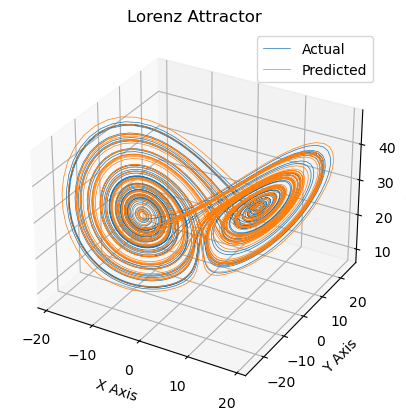

In [26]:
# Plot
ax = plt.figure().add_subplot(projection='3d')

x_data = valid_data[:, 0]
y_data = valid_data[:, 1]
z_data = valid_data[:, 2]

x_pred = predicted_data[:, 0]
y_pred = predicted_data[:, 1]
z_pred = predicted_data[:, 2]

ax.plot(x_data, y_data, z_data, lw=0.5, label="Actual")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, label="Predicted")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()
ax.set_title("Lorenz Attractor")

plt.show()

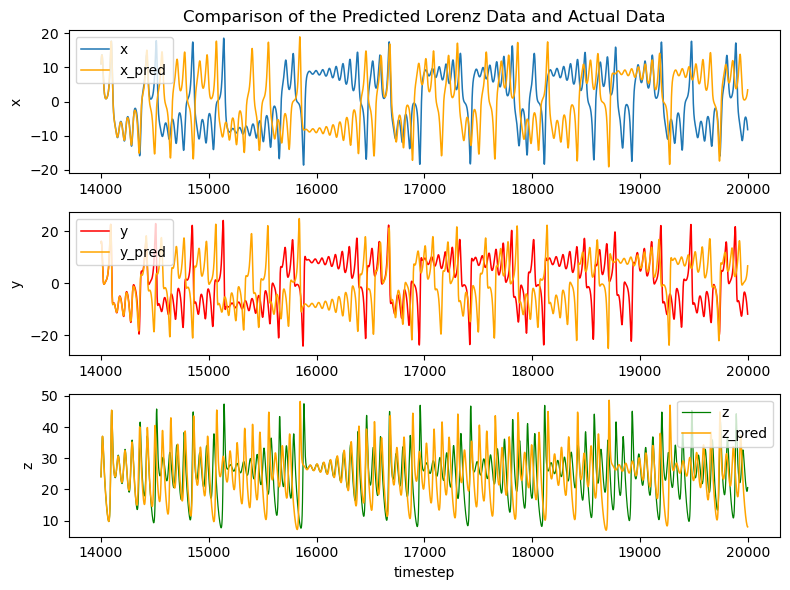

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

# Plot data on each subplot
timesteps = [*range(training_data.shape[0], data_length, 1)]

axs[0].plot(timesteps, x_data, label="x", lw=1.1)
axs[0].plot(timesteps, x_pred, label="x_pred", color='orange', lw=1.1)  # I changed the label to 'x_pred' for clarity
axs[0].set_ylabel("x")
axs[0].set_title("Comparison of the Predicted Lorenz Data and Actual Data")
axs[0].legend()

axs[1].plot(timesteps, y_data, label="y", color='r', lw=1.1)
axs[1].plot(timesteps, y_pred, label="y_pred", color='orange', lw=1.1)  # I changed the label to 'y_pred' for clarity
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(timesteps, z_data, label="z", color='g', lw=.9)
axs[2].plot(timesteps, z_pred, label="z_pred", color='orange', lw=1.1)  # I changed the label to 'z_pred' for clarity
axs[2].set_ylabel("z")
axs[2].set_xlabel("timestep")
axs[2].legend()

fig.tight_layout()

plt.show()